In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

Using PyTorch version: 2.0.0+cpu Device: cpu


In [3]:
BATCH_SIZE =32
EPOCHS = 10

In [4]:
train_dataset= datasets.MNIST(root = "../data/MNIST,",
                              train = True,
                              download=True,
                              transform =transforms.ToTensor())

test_dataset= datasets.MNIST(root="../data/MNIST",
                             train = False,
                             download=True,
                             transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size= BATCH_SIZE,
                                           shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)



In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


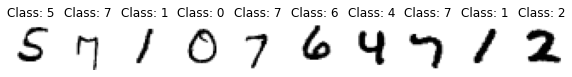

In [6]:
pltsize =1
plt.figure(figsize=(10* pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap= 'gray_r')
    plt.title('Class: '+ str(y_train[i].item()))

    

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x= self.fc1(x)
        x= F.sigmoid(x)
        x=F.dropout(x, training = self.training, p= self.dropout_prob)
        x= self.fc2(x)
        x= F.sigmoid(x)
        x= F.dropout(x, training = self.training, p= self.dropout_prob)
        x= self.fc3(x)
        x= F.log_softmax(x, dim =1)
        return x


In [10]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval ==0 :
            print("Train Epoch: {} [{}/{}{:.0f}%]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct=0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim =True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 *correct/ len(test_loader.dataset)
    return test_loss, test_accuracy

In [14]:
for Epoch in range(1, EPOCHS +1):
    train(model, train_loader, optimizer, log_interval =200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/600000%]	Train Loss: 2.346673
Train Epoch: 1 [6400/6000011%]	Train Loss: 2.335307
Train Epoch: 1 [12800/6000021%]	Train Loss: 2.278524
Train Epoch: 1 [19200/6000032%]	Train Loss: 2.340184
Train Epoch: 1 [25600/6000043%]	Train Loss: 2.335945
Train Epoch: 1 [32000/6000053%]	Train Loss: 2.282367
Train Epoch: 1 [38400/6000064%]	Train Loss: 2.269466
Train Epoch: 1 [44800/6000075%]	Train Loss: 2.262807
Train Epoch: 1 [51200/6000085%]	Train Loss: 2.287188
Train Epoch: 1 [57600/6000096%]	Train Loss: 2.242288

[EPOCH: 1], 	Test Loss: 0.0700, 	Test Accuracy: 21.63 %

Train Epoch: 2 [0/600000%]	Train Loss: 2.296594
Train Epoch: 2 [6400/6000011%]	Train Loss: 2.179135
Train Epoch: 2 [12800/6000021%]	Train Loss: 2.213916
Train Epoch: 2 [19200/6000032%]	Train Loss: 2.081136
Train Epoch: 2 [25600/6000043%]	Train Loss: 2.029723
Train Epoch: 2 [32000/6000053%]	Train Loss: 1.914353
Train Epoch: 2 [38400/6000064%]	Train Loss: 1.735379
Train Epoch: 2 [44800/6000075%]	Train Loss: 1.638823
